In [24]:
import ChannelSim
import matplotlib.pyplot as plt
import scipy.stats
import scipy.special
import numpy as np

In [25]:
#######################################
# Parameters
#######################################

# The rectangular region specifying the environment, indicating the upper
# right and lower left corners of the workspace
x_max = 6
x_min = -4
y_max = 5.5
y_min = -5
region = [x_max, x_min, y_max, y_min]

# Position of the base station (remote station or transmitter)
q_b = [0, 0]

# Path loss parameters
# The resulting path loss component in dB is 
# gamma_PL_dB = K_PL - 10 * n_PL * log10(d), where d is the distance to the base station.
# K_PL is the path loss constant in dB and n_PL is the path loss exponent.
n_PL = 3
K_PL = -12.89


# Shadowing parameters
# alpha : power of the shadowing (in dB)
# beta : decorrelation distance (in meter). The shadowing correlation
#        model we use is: alpha*exp(-distance/beta).
# N_sin : # of sinusoids to use, this is arbitrary. The higher the number
#         the more accurate the generation of the correlated shadowing will
#         be. However, if it is too high, the computational cost is
#         significant. We have seen that 5000 provides a good balance
#         between accuracy and computational time.
# PSD_at_f_c : The amplitude difference (in dB) between PSD of shadowing at
#              cutoff frequency and at frequency 0, which is used to find
#              the cutoff frequency. The cutoff frequency is used to approximate
#              the desired shadowing PSD, which has a "low pass" shape
#              (see JOR Eq. 24 for the mathematical expression of the shadowing
#              PSD). The portion of the PSD beyond the cutoff frequency will 
#              be ignored in the approximation.
#              See the JOR paper (Section 6) for more details.

alpha = 10;            
beta = 2;                        
N_sin = 5000;                    
PSD_at_f_c = 30;                  


# Multipath fading parameters
# lambda: the wavelength of transmission (in meter)
# res = the resolution of the grid (in samples/m) = 1/(dis between 2 samples along x or y axis)
# K_ric = parameter of the Rician distribution (see Goldsmith page 79)

# lambda = 0.125 corresponds to a carrier frequency of 2.4 GHz.
lam = 0.125

# ss_decorr is the decorrelation distance for multipath fading.
# This is the point where J_0(2*pi*ss_decorr/lambda) is equal to 0 (see Eq. 3.26 of Goldsmith).
# Note that ss_decorr = 0.4*lambda.
# This variable is not an input to the channel simulator, but is used to 
# to provide a guideline for choosing the simulation resoltuion.
ss_decorr = 0.05        

# This makes 1/res = ss_decorr/2.
# Make sure 1/res < ss_decorr so that we can see some correlation.
res = 2/ss_decorr

K_ric = 10     


In [26]:
#######################################
# Generate the channel
#######################################
print('generating the channel...\n')


# corr_mp = 1 -> correlated multipath 
# corr_mp = 0 -> uncorrelated multipath 
corr_mp = 0;
gamma_TOT_dB, gamma_PL_SH_dB, gamma_PL_dB, gamma_SH_dB, gamma_MP_LIN, g_x, g_y \
= ChannelSim.channel_simulator(region, q_b, K_PL, n_PL, alpha, beta, N_sin, PSD_at_f_c, lam, K_ric, res, corr_mp)

generating the channel...


grid size = 6720000 pixels

generating path loss...

generating shadowing...

generating multipath fading...



In [27]:
def plot_channel(g_x, g_y, channel_vals, title):
    fnt_siz = 10
    """
    Plot PL (dB)
    """
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15,10))

    surf = ax.plot_surface(g_x, g_y, channel_vals, linewidth=0);
    # light
    # shading interp
    plt.xlabel('x (m)', fontsize= fnt_siz,  fontweight = 'bold')
    plt.ylabel('y (m)', fontsize= fnt_siz,  fontweight = 'bold')
    ax.set_zlabel(title, fontsize= fnt_siz,  fontweight = 'bold')
    plt.show()

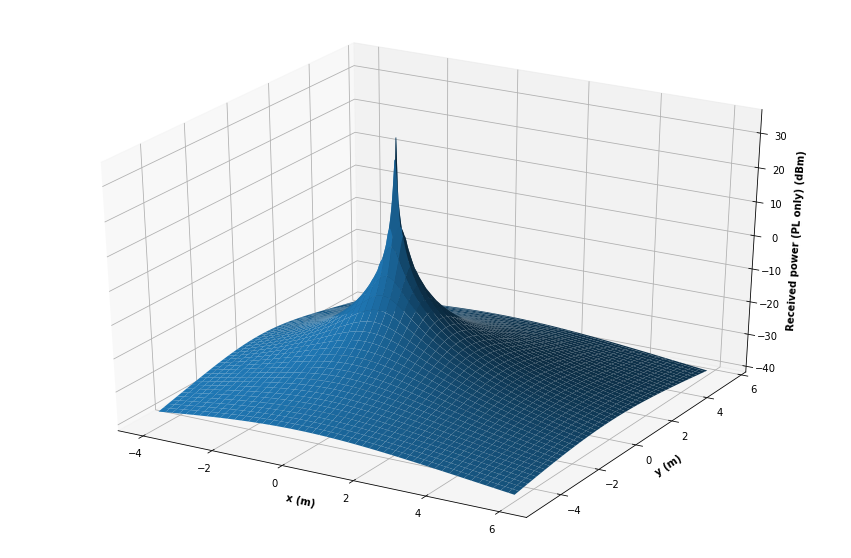

In [28]:
"""
Plot PL (dB)
"""
plot_channel(g_x, g_y, gamma_PL_dB, 'Received power (PL only) (dBm)')

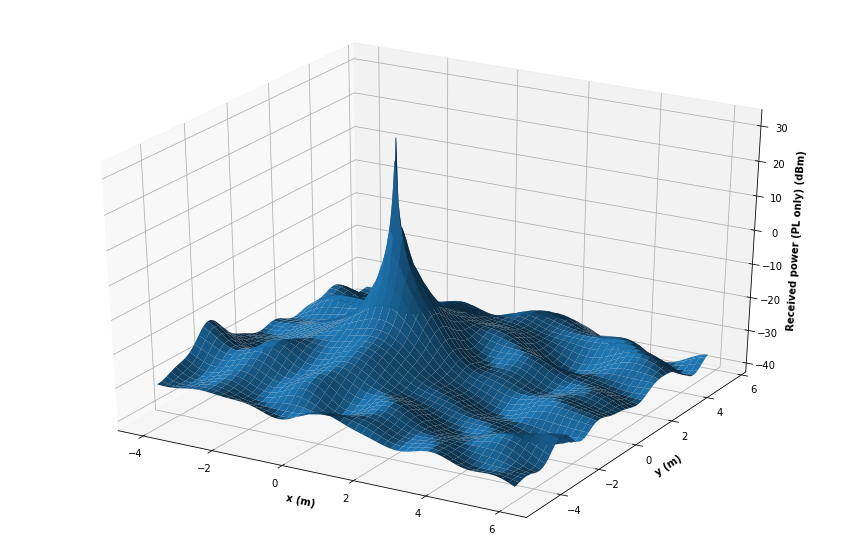

In [29]:
"""
Plot PL + SH (dB)
"""
plot_channel(g_x, g_y, gamma_PL_SH_dB, 'Received power (PL + SH) (dBm)')

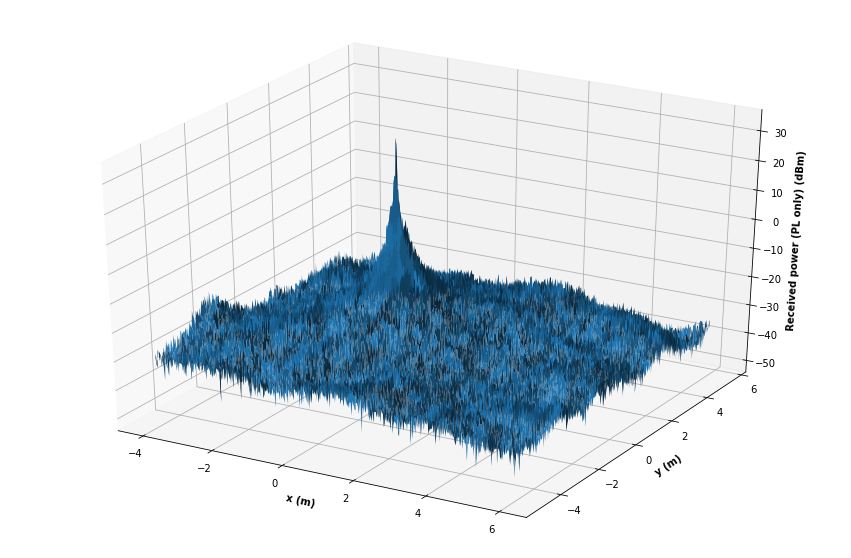

In [30]:
"""
Plot Total (dB)
"""
plot_channel(g_x, g_y, gamma_TOT_dB, 'Received power (PL + SH + MP) (dBm)')

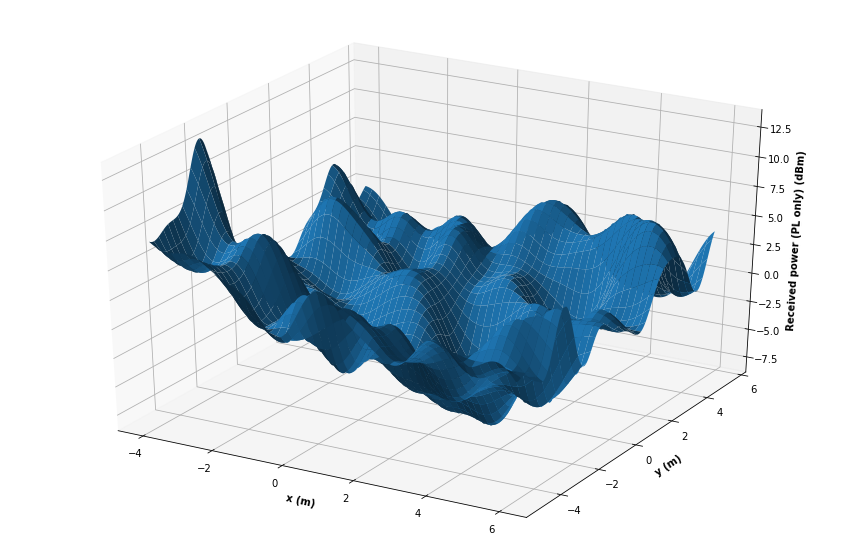

In [31]:
"""
Plot Total (dB)
"""
plot_channel(g_x, g_y, gamma_SH_dB, 'Received power (SH only) (dBm)')

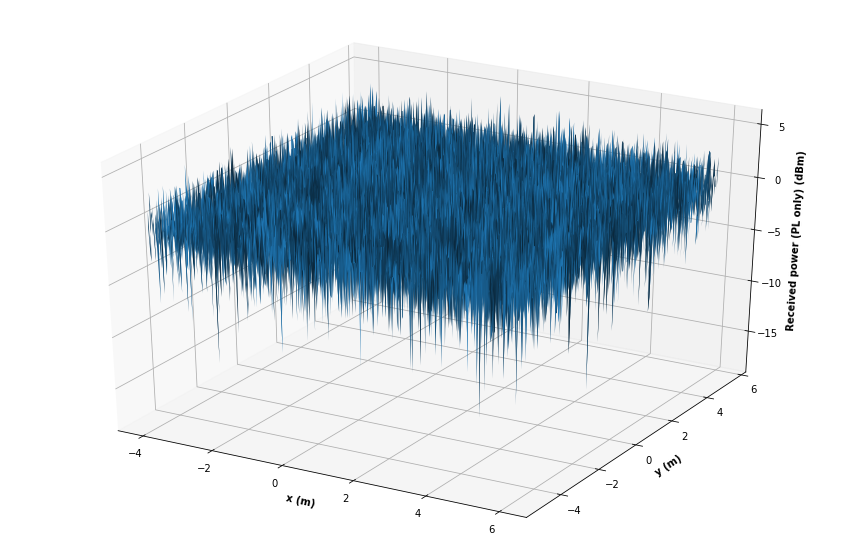

In [32]:
"""
Plot Total (dB)
"""
plot_channel(g_x, g_y, gamma_TOT_dB - gamma_PL_SH_dB, 'Received power (MP only) (dBm)')

Testing the gaussian match for the generated shadowing...
The mean of the generated shadowing component in dB :  0.00
The var of the generated shadowing component and its desired value: 10.00, 10.00



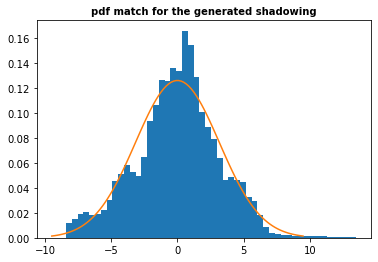

In [33]:
##############################################
# Test the Gaussian match for the generated shadowing component
##############################################


print('Testing the gaussian match for the generated shadowing...')

# Fit a normal dist. to the generated shadowing 
mean_SH_num, sigma_SH_num = scipy.stats.norm.fit(gamma_SH_dB)

print('The mean of the generated shadowing component in dB : %5.2f'%(mean_SH_num))
print('The var of the generated shadowing component and its desired value: %5.2f, %5.2f\n'%(sigma_SH_num**2, alpha))

fnt_siz = 10
fig = plt.figure()
plt.hist(gamma_SH_dB.flatten(), 50,density = True)
x = np.linspace(mean_SH_num - 3*sigma_SH_num, mean_SH_num + 3*sigma_SH_num, 100)
plt.plot(x, scipy.stats.norm.pdf(x, mean_SH_num, sigma_SH_num))
plt.title('pdf match for the generated shadowing', fontsize = fnt_siz,  fontweight = 'bold')
plt.show()

In [34]:
#######################################################################
# calculating mean and variance of Rician in dB
#
# usage 
#-----------------------
# [sigma_2_mp, mean_mp] = calc_power_mp_given_K_ric(K_ric)
#
# The mean and variance are calculated by direct integration 
#
# inputs
#-------------------------
# K_ric      : rician K factor (k = 0 results in Rayleigh dist.)
# 
# outputs
#-------------------------
# sigma_2_mp : the variance of Rician fading in dB domain
# mean_mp    : the mean of Rician fading in dB domain
#
# Original codes courtesy of Alireza Ghaffarkhah and Alejandro Gonzalez-Ruiz
# Updated by Herbert Cai (April 2016)
# Translated to python by Winsotn HUrst (April 2021)
#
# If you have any questions or comments regarding the codes,
# please contact Winston Hurst at winstonhurst@ece.ucsb.edu
#
# Dept. of Electrical and Computer Engineering
# University of California, Santa Barbara
#######################################################################

def calc_power_mp_given_K_ric(K_ric):
    x = np.linspace(0.01,10.01, int(10/0.01))

    # the PDF of Rician fading in linear domain
    p = (1+K_ric)*np.exp(-K_ric - (K_ric + 1)*x) * scipy.special.iv(0, 2*np.sqrt(x*K_ric*(K_ric + 1)))

    # trapz integration 
    y1 = 100*(np.log10(x))**2 * p
    y2 = 10*np.log10(x)*p

    #trapz does a numerical integration via the trapezoidal method
    T1 = np.trapz(y1,x)
    T2 = np.trapz(y2, x)

    mean_mp = T2
    sigma_2_mp = T1 - T2**2

    return sigma_2_mp, mean_mp

Testing the rician match for the generated multipath...

The mean of the generated multipath component in dB and its desired value : -0.40, -0.41

The var of the generated multipath component and its desired value:  3.96,  3.99



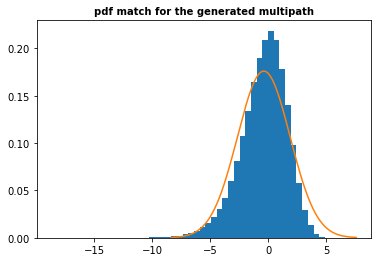

In [37]:
#############################################
# Test the Rician match for the generated multipath component
#############################################

print('Testing the rician match for the generated multipath...')

gamma_MP_dB = 10*np.log10(gamma_MP_LIN)

#theoretical (desired) values of the mean and variance of multipath component in dB
sigma_2_MP_theo, mean_MP_theo = calc_power_mp_given_K_ric(K_ric)

# numerical values of the mean and variance of multipath component in dB
mean_MP_num = np.mean(gamma_MP_dB)
sigma_2_MP_num = np.var(gamma_MP_dB)


print('\nThe mean of the generated multipath component in dB and its desired value : %5.2f, %5.2f\n'%( mean_MP_num, mean_MP_theo))
print('The var of the generated multipath component and its desired value: %5.2f, %5.2f\n'%(sigma_2_MP_num, sigma_2_MP_theo))

sigma_MP_num = np.sqrt(sigma_2_MP_num)
num_fit_params = scipy.stats.rice.fit(gamma_MP_dB)

fig = plt.figure()
plt.hist(gamma_MP_dB.flatten(), 50, density = True)
x = np.linspace(mean_MP_num - 4*sigma_MP_num, mean_MP_num + 4*sigma_MP_num, 1000)
plt.plot(x, scipy.stats.rice.pdf(x, *num_fit_params))
plt.title('pdf match for the generated multipath', fontsize = fnt_siz,  fontweight = 'bold')
plt.show()